In [1]:
import os
import numpy as np
from pyspark.sql import SparkSession, DataFrame
from pyspark import SparkConf
from pyspark.sql.functions import (
    col, lit, sum, mean, when,
    explode, count, desc, floor,
    corr, array_contains, lit, first, size
)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Вспомогательные функции

In [2]:
def create_spark_configuration() -> SparkConf:
    """
    Создает и конфигурирует экземпляр SparkConf для приложения Spark.

    Returns:
        SparkConf: Настроенный экземпляр SparkConf.
    """
    # Получаем имя пользователя
    user_name = "dchel"
    
    conf = SparkConf()
    conf.setAppName("Lab 1")
    conf.setMaster("local[*]")
    conf.set("spark.submit.deployMode", "client")
    conf.set("spark.executor.memory", "12g")
    conf.set("spark.executor.cores", "8")
    conf.set("spark.executor.instances", "2")
    conf.set("spark.driver.memory", "4g")
    conf.set("spark.driver.cores", "2")
    # conf.set("spark.jars.packages", "org.apache.iceberg:iceberg-spark-runtime-3.5_2.12:1.6.0")
    # conf.set("spark.sql.extensions", "org.apache.iceberg.spark.extensions.IcebergSparkSessionExtensions")
    # conf.set("spark.sql.catalog.spark_catalog", "org.apache.iceberg.spark.SparkCatalog")
    conf.set("spark.sql.catalog.spark_catalog.type", "hadoop")
    conf.set("spark.sql.catalog.spark_catalog.warehouse", f"hdfs:///user/{user_name}")
    conf.set("spark.sql.catalog.spark_catalog.io-impl", "org.apache.iceberg.hadoop.HadoopFileIO")

    return conf

In [3]:
def count_nulls(data: DataFrame,
                column_name: str) -> None:
    """
    Подсчет количества null и not null значений в указанном столбце.

    Args:
        data (DataFrame): DataFrame, содержащий данные.
        column_name (str): Имя столбца для подсчета null и not null значений.
    
    Returns:
        None
    """
    # Подсчет количества null значений в указанном столбце
    null_counts = data.select(
        sum(col(column_name).isNull().cast("int"))
    ).collect()[0][0]

    # Подсчет количества not null значений в указанном столбце
    not_null_counts = data.select(
        sum(col(column_name).isNotNull().cast("int"))
    ).collect()[0][0]

    # Вывод результатов
    print(f"Число колонок с NULL: {null_counts} "
          f"({100 * null_counts / (null_counts + not_null_counts):.2f}%)")

In [4]:
def plot_cat_distribution(data,
                          column_name: str,
                          top_n: int = 20) -> None:
    """
    Построение распределения категориального признака.

    Args:
        data (DataFrame): DataFrame, содержащий данные.
        column_name (str): Имя столбца для группировки.
        top_n (int): Количество топ-значений для отображения.
    
    Returns:
        None
    """
     # Проверяем тип данных колонки
    column_type = dict(data.dtypes)[column_name]
    
    if column_type == 'array<string>':
        # Обработка массива - разворачиваем элементы
        categories = (
            data
            .select(explode(col(column_name)).alias(column_name))
            .groupBy(column_name)
            .count()
            .orderBy("count", ascending=False)
        )
    else:
        # Обработка обычной колонки
        categories = (
            data
            .groupBy(column_name)
            .count()
            .orderBy("count", ascending=False)
        )
    
    total_categories = categories.count()
    print(f"Количество категорий признака {column_name}: {total_categories}")

    # Берем топ-N категорий и собираем в Python список
    categories_list = categories.limit(top_n).collect()
    
    # Создаем списки для данных
    category_names = []
    category_counts = []
    
    for row in categories_list:
        category_names.append(row[column_name])
        category_counts.append(row['count'])
    
    # Визуализация с использованием matplotlib (без seaborn)
    plt.figure(figsize=(12, 8))
    plt.bar(category_names, category_counts)
    plt.title(f"Barplot of \"{column_name}\" counts (Top {top_n})")
    plt.xlabel(column_name)
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # Дополнительная информация
    if total_categories > top_n:
        print(f"Показаны топ-{top_n} категорий из {total_categories}")

In [5]:
def plot_boxplots(data: DataFrame,
                  columns: list[str],
                  sample_fraction: float = 0.1) -> None:
    """
    Построение boxplot для нескольких столбцов в PySpark DataFrame.

    Args:
        data (DataFrame): DataFrame, содержащий данные.
        columns (list of str): Список имен столбцов для построения boxplot.
        sample_fraction (float): Доля данных для семплирования выбросов.
    
    Returns:
        None
    """
    box_data = []

    for column in columns:
        # Вычисление квантилей
        quantiles = data.approxQuantile(column, [0.25, 0.5, 0.75], 0.01)
        q1, median, q3 = quantiles

        # Вычисление IQR и границ усов
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        # Фильтрация выбросов
        filtered_df = data.filter((col(column) >= lower_bound) & (col(column) <= upper_bound))
        outliers_df = data.filter((col(column) < lower_bound) | (col(column) > upper_bound))

        # Вычисление минимального и максимального значений
        min_value = data.agg({column: "min"}).collect()[0][0]
        mean_value = data.agg({column: "mean"}).collect()[0][0]
        std_value = data.agg({column: "std"}).collect()[0][0]
        max_value = data.agg({column: "max"}).collect()[0][0]

        # Ограничение усов минимальным и максимальным значениями
        lower_bound = max(lower_bound, min_value)
        upper_bound = min(upper_bound, max_value)

        # Семплирование выбросов
        outliers = []
        if not outliers_df.isEmpty():
            sampled_outliers_df = outliers_df.sample(sample_fraction)
            outliers = (
                sampled_outliers_df
                .select(column)
                .limit(1000)
                .collect()
            )
            outliers = [row[column] for row in outliers]
            
            # Добавление минимального и максимального значений, если они 
            # относятся к выбросам и не присутствуют в семпле
            if min_value < lower_bound and min_value not in outliers:
                outliers.append(min_value)
            if max_value > upper_bound and max_value not in outliers:
                outliers.append(max_value)

        # Подготовка данных для axes.bxp
        box_data.append({
            'whislo': lower_bound,  # Нижняя граница усов
            'q1': q1,               # Первый квартиль
            'med': median,          # Медиана
            'q3': q3,               # Третий квартиль
            'whishi': upper_bound,  # Верхняя граница усов
            'fliers': outliers      # Выбросы
        })
        
    # Вывод статистических характеристик
    print(f"Минимальное значение:          {min_value:.2f}")
    print(f"Среднее значение:              {mean_value:.2f}")
    print(f"Среднеквадратичное отклонение: {std_value:.2f}")
    print(f"Первый квартиль:               {q1:.2f}")
    print(f"Медиана:                       {median:.2f}")
    print(f"Третий квартиль:               {q3:.2f}")
    print(f"Максимальное значение:         {max_value:.2f}")

    # Построение boxplot
    fig, ax = plt.subplots(figsize=(20, 6))
    ax.bxp(box_data, 
           vert=False, 
           positions=range(1, len(columns) + 1), widths=0.5)
    ax.set_yticks(range(1, len(columns) + 1))
    ax.set_yticklabels(columns)
    ax.set_xlabel('Value')
    ax.set_title('Boxplots')
    ax.grid(True)
    plt.show()

In [6]:
def plot_quant_distribution(data: DataFrame,
                          column: str,
                          num_bins: int = 200) -> None:
    """
    Построение гистограммы для количественной переменной с 
    использованием PySpark и matplotlib.

    Args:
        data (DataFrame): DataFrame с данными.
        column (str): Название колонки с количественной переменной.
        num_bins (int): Количество бинов для гистограммы.

    Returns:
        None
    """
    try:
        # Получаем min и max отдельными запросами
        min_value = data.selectExpr(f"min({column})").collect()[0][0]
        max_value = data.selectExpr(f"max({column})").collect()[0][0]
        
        print(f"📊 Диапазон значений {column}: {min_value:.2f} - {max_value:.2f}")

        # Размер бина
        bin_size = (max_value - min_value) / num_bins

        # Добавляем колонку с номером бина используя selectExpr
        data_with_bin = data.selectExpr(
            "*", 
            f"floor(({column} - {min_value}) / {bin_size}) as bin"
        ).filter(f"bin < {num_bins}")

        # Группируем по номеру бина и считаем количество строк
        bin_counts = data_with_bin.groupBy("bin").count().orderBy("bin")

        # Собираем результаты
        bin_counts_list = bin_counts.collect()
        
        # Создаем массивы для данных
        bin_indices = []
        bin_values = []
        
        for row in bin_counts_list:
            bin_indices.append(row['bin'])
            bin_values.append(row['count'])
        
        # Создаем центры бинов
        bin_centers = [min_value + (bin_idx + 0.5) * bin_size for bin_idx in bin_indices]
        
        # Построение гистограммы
        plt.figure(figsize=(20, 6))
        plt.bar(bin_centers, bin_values, width=bin_size * 0.8, 
                alpha=0.7, color='skyblue', edgecolor='navy', linewidth=0.5)
        plt.xlabel("Value", fontsize=20)
        plt.ylabel("Count", fontsize=20)
        plt.title(f"Распределение количественного признака \"{column}\"")
        plt.grid(True, alpha=0.3)
        
        # Форматируем оси для больших чисел
        plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"❌ Ошибка при построении гистограммы: {e}")
        import traceback
        traceback.print_exc()

In [7]:
def add_options_columns(data: DataFrame,
                        column: str,
                        popular_options: DataFrame) -> DataFrame:
    """
    Добавление новых булевых колонок в DataFrame, указывающих, 
    содержится ли определённый элемент в каждой строке.

    Args:
        data (DataFrame): DataFrame, содержащий данные.
        column (str): Имя столбца с массивом.
        popular_elements (DataFrame): DataFrame с популярными элементами.

    Returns:
        DataFrame: DataFrame с новыми булевыми колонками.
    """
    # Добавление булевых колонок для каждой популярной категории
    categories_df = popular_options.select(col("element").alias("category"))
    result = data.crossJoin(categories_df.hint("broadcast"))
    result = result.withColumn("contains", 
                               array_contains(col(column), col("category")))
    result = result.groupBy(data.columns).pivot("category").agg(first("contains"))
    
    for col_name in result.columns:
        if col_name not in data.columns:
            result = result.withColumnRenamed(col_name, f"contains_{col_name}")
    
    return result

In [8]:
def get_popular_options(data: DataFrame, 
                        column: str, 
                        top_n: int = 5) -> DataFrame:
    """
    Получение DataFrame всех элементов массива опций, подсчет их количества, 
    сортировка по убыванию и вывод нескольких самых популярных элементов.

    Args:
        data (DataFrame): DataFrame, содержащий данные.
        column (str): Имя столбца с массивом.
        top_n (int): Количество самых популярных элементов для вывода.

    Returns:
        DataFrame: DataFrame с самыми популярными элементами.
    """
    # Развертывание массива в отдельные строки
    exploded_df = data.withColumn("element", explode(col(column)))

    # Подсчет количества каждого элемента
    element_counts = (
        exploded_df
        .groupBy("element")
        .agg(count("element").alias("count"))
    )

    # Сортировка элементов по убыванию
    sorted_elements = element_counts.orderBy(desc("count"))

    # Вывод нескольких самых популярных элементов
    top_elements = sorted_elements.limit(top_n)

    return top_elements

In [9]:
def plot_pie_chart(data: DataFrame,
                   column_name: str,
                   top_n: int = 10,
                   title: str = None,
                   figsize: tuple = (10, 8)) -> None:
    """
    Построение pie chart для категориального признака.

    Args:
        data (DataFrame): Spark DataFrame с данными
        column_name (str): Имя столбца для анализа
        top_n (int): Количество топ-категорий для отображения
        title (str): Заголовок графика
        figsize (tuple): Размер фигуры
    """
    import builtins
    
    # Проверяем тип данных колонки
    column_type = dict(data.dtypes)[column_name]
    
    if column_type == 'array<string>':
        # Для массивов - разворачиваем элементы
        categories_df = (
            data
            .select(explode(col(column_name)).alias(column_name))
            .filter(col(column_name).isNotNull())
            .groupBy(column_name)
            .count()
            .orderBy("count", ascending=False)
        )
    else:
        # Для обычных колонок
        categories_df = (
            data
            .filter(col(column_name).isNotNull())
            .groupBy(column_name)
            .count()
            .orderBy("count", ascending=False)
        )
    
    # Собираем все категории
    all_categories = categories_df.collect()
    total_categories = len(all_categories)
    
    # Если категорий больше top_n, группируем остальные в "Other"
    if total_categories > top_n:
        top_categories = all_categories[:top_n]
        other_count = sum(row['count'] for row in all_categories[top_n:])
        
        # Создаем финальные списки
        labels = [str(row[column_name]) for row in top_categories] + ['Other']
        sizes = [row['count'] for row in top_categories] + [other_count]
    else:
        labels = [str(row[column_name]) for row in all_categories]
        sizes = [row['count'] for row in all_categories]
    
    total = builtins.sum(sizes)
    
    # Создание pie chart
    plt.figure(figsize=figsize)
    
    # Автоматический заголовок если не указан
    if title is None:
        title = f'Распределение по столбцу: {column_name}'
    
    # Создаем pie chart с процентами
    patches, texts, autotexts = plt.pie(
        sizes, 
        labels=labels, 
        autopct='%1.1f%%',
        startangle=90,
        shadow=False,
        textprops={'fontsize': 12}
    )
    
    # Улучшаем отображение процентов
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
    
    plt.title(title, fontsize=14, fontweight='bold', pad=20)
    plt.axis('equal')  # Чтобы pie chart был круглым
    
    # Добавляем легенду
    plt.legend(
        patches,
        [f'{label}: {count} ({count/total*100:.1f}%)' for label, count in zip(labels, sizes)],
        title="Категории",
        loc="center left",
        bbox_to_anchor=(1, 0, 0.5, 1)
    )
    
    plt.tight_layout()
    plt.show()
    
    # Выводим статистику
    print(f"Всего категорий: {total_categories}")
    print(f"Показано категорий: {len(labels)}")
    print(f"Общее количество записей: {total:,}")

In [10]:
def compute_and_visualize_correlation_matrix(data: DataFrame, 
                                             columns: list[str]) -> None:
     # Проверяем доступные колонки
    available_columns = set(data.columns)
    columns = [col for col in columns if col in available_columns]
    
    if not columns:
        print("❌ Нет доступных колонок для анализа")
        return
    
    print(f"🔍 Анализируем колонки: {columns}")
    
    # Создаем копию DataFrame
    df_processed = data
    
    # Словарь для преобразованных имен колонок
    transformed_columns = {}
    numeric_columns = []
    
    # Преобразуем каждую колонку в числовой формат
    for column in columns:
        column_type = dict(data.dtypes)[column]
        print(f"  {column}: {column_type}")
        
        if column_type in ['int', 'bigint', 'double', 'float', 'decimal']:
            # Колонка уже числовая
            numeric_columns.append(column)
            transformed_columns[column] = column
            
        elif column_type == 'string':
            # Для строковых колонок используем простую нумерацию (label encoding)
            new_col_name = f"{column}_encoded"
            
            # Создаем mapping уникальных значений в числа
            unique_values = data.select(column).distinct().rdd.flatMap(lambda x: x).collect()
            value_to_num = {val: idx for idx, val in enumerate(unique_values)}
            
            # Создаем UDF для преобразования
            from pyspark.sql.functions import udf
            from pyspark.sql.types import IntegerType
            
            mapping_udf = udf(lambda x: value_to_num.get(x, -1), IntegerType())
            df_processed = df_processed.withColumn(new_col_name, mapping_udf(col(column)))
            
            numeric_columns.append(new_col_name)
            transformed_columns[column] = new_col_name
            print(f"    → преобразована в label encoding ({len(unique_values)} уникальных значений)")
            
        elif column_type == 'array<string>':
            # Для массивов используем длину массива как числовой признак
            new_col_name = f"{column}_length"
            df_processed = df_processed.withColumn(
                new_col_name, 
                when(col(column).isNull(), 0).otherwise(size(col(column)))
            )
            
            numeric_columns.append(new_col_name)
            transformed_columns[column] = new_col_name
            print(f"    → преобразована в длину массива")
            
        else:
            print(f"    ⚠️ неподдерживаемый тип: {column_type}")
    
    if not numeric_columns:
        print("❌ Нет числовых колонок для анализа корреляции")
        return
    
    print(f"📊 Числовые колонки для корреляции: {numeric_columns}")
    
    # Вычисление корреляционной матрицы
    corr_matrix = {}
    for col1 in numeric_columns:
        corr_matrix[col1] = {}
        for col2 in numeric_columns:
            try:
                corr_value = df_processed.select(corr(col1, col2)).collect()[0][0]
                corr_matrix[col1][col2] = corr_value if corr_value is not None else 0.0
            except Exception as e:
                print(f"❌ Ошибка при вычислении корреляции {col1} и {col2}: {e}")
                corr_matrix[col1][col2] = 0.0
    
    # Создаем понятные названия для визуализации
    display_names = {}
    for original, transformed in transformed_columns.items():
        if original == transformed:
            display_names[transformed] = original
        else:
            clean_name = transformed.replace('_encoded', '').replace('_length', ' (len)')
            display_names[transformed] = clean_name
    
    # Преобразование в DataFrame Pandas и визуализация
    corr_matrix_pd = pd.DataFrame(corr_matrix)
    corr_matrix_pd.index = [display_names.get(col, col) for col in corr_matrix_pd.index]
    corr_matrix_pd.columns = [display_names.get(col, col) for col in corr_matrix_pd.columns]
    
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(corr_matrix_pd, dtype=bool))
    
    sns.heatmap(corr_matrix_pd, 
                annot=True, 
                cmap='RdBu_r', 
                center=0,
                linewidths=0.5, 
                square=True,
                mask=mask,
                fmt='.3f',
                cbar_kws={'shrink': 0.8})
    
    plt.title('Матрица корреляций', fontsize=16, fontweight='bold', pad=20)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Статистика
    corr_values = corr_matrix_pd.values[np.triu_indices_from(corr_matrix_pd, k=1)]
    print(f"\n📈 Статистика корреляций:")
    print(f"   Проанализировано колонок: {len(numeric_columns)}")
    print(f"   Максимальная корреляция: {corr_values.max():.3f}")
    print(f"   Минимальная корреляция: {corr_values.min():.3f}")
    print(f"   Средняя корреляция: {corr_values.mean():.3f}")

## Создание Spark сессии

In [11]:
conf = create_spark_configuration()
spark = SparkSession.builder.config(conf=conf).getOrCreate()
spark

In [12]:
database_name = "dchel_database"
table_name = "eCommerce_table"
path = f"hdfs://namenode:9000/user/dchel/{database_name}/{table_name}"
df = spark.read.parquet(path)
df.show()
df.printSchema()
df.count()

+----------+----------+-----------+--------------------+--------+------+
|event_type|product_id|category_id|       category_code|   brand| price|
+----------+----------+-----------+--------------------+--------+------+
|      view|   1004767|       NULL|[electronics, sma...| samsung|250.82|
|      view|   1307135|       NULL|[computers, noteb...|      hp| 262.3|
|      view|   1005186|       NULL|[electronics, sma...| samsung|771.94|
|      cart|   1801911|       NULL|[electronics, vid...| samsung|1001.0|
|      view|  10900003|       NULL|[appliances, kitc...| polaris| 40.85|
|      cart|   2702050|       NULL|[appliances, kitc...|      lg|489.96|
|      view|   1004249|       NULL|[electronics, sma...|   apple|766.76|
|      view|   6200358|       NULL|[appliances, envi...| almacom| 43.76|
|      view|   1004856|       NULL|[electronics, sma...| samsung|131.64|
|      view|   3601376|       NULL|[appliances, kitc...|   candy|254.81|
|      view|   1004856|       NULL|[electronics, sm

26560622

## Выявление и удаление дубликатов

In [13]:
(
    df
    .groupBy("product_id")
    .count()
    .where("count > 1")
    .orderBy("count", ascending=False)
    .show()
)

+----------+------+
|product_id| count|
+----------+------+
|   1004856|500354|
|   1004767|438232|
|   1005115|355786|
|   1004833|237545|
|   1004249|231070|
|   1004870|220501|
|   1005105|215598|
|   4804056|214234|
|   1002544|205597|
|   1004741|167491|
|   1004836|165769|
|   1004873|153992|
|   1004739|150870|
|   1005160|139673|
|   1002524|134206|
|   1004785|126394|
|   1002633|123521|
|   1005100|122286|
|   1004750|121626|
|   4804295|117479|
+----------+------+
only showing top 20 rows



In [14]:
df.filter(col("product_id") == "1004856").show()

+----------+----------+-----------+--------------------+-------+------+
|event_type|product_id|category_id|       category_code|  brand| price|
+----------+----------+-----------+--------------------+-------+------+
|      view|   1004856|       NULL|[electronics, sma...|samsung|131.64|
|      view|   1004856|       NULL|[electronics, sma...|samsung|131.64|
|      view|   1004856|       NULL|[electronics, sma...|samsung|131.64|
|      view|   1004856|       NULL|[electronics, sma...|samsung|131.64|
|      view|   1004856|       NULL|[electronics, sma...|samsung|131.64|
|      view|   1004856|       NULL|[electronics, sma...|samsung|131.64|
|      view|   1004856|       NULL|[electronics, sma...|samsung|131.64|
|      view|   1004856|       NULL|[electronics, sma...|samsung|131.64|
|      view|   1004856|       NULL|[electronics, sma...|samsung|131.64|
|      view|   1004856|       NULL|[electronics, sma...|samsung|131.64|
|      cart|   1004856|       NULL|[electronics, sma...|samsung|

In [15]:
df = df.dropDuplicates(["product_id", "event_type", "price"])
df.count()

224113

In [16]:
df.show()

+----------+----------+-----------+--------------------+-------+------+
|event_type|product_id|category_id|       category_code|  brand| price|
+----------+----------+-----------+--------------------+-------+------+
|      view|   1001588|       NULL|[electronics, sma...|  meizu| 128.3|
|  purchase|   1002062|       NULL|[electronics, sma...|samsung| 77.14|
|  purchase|   1002101|       NULL|[electronics, sma...|samsung|370.41|
|      view|   1002398|       NULL|[electronics, sma...|   sony|251.99|
|      view|   1002398|       NULL|[electronics, sma...|   sony|252.03|
|      view|   1002398|       NULL|[electronics, sma...|   sony|252.11|
|      view|   1002442|       NULL|[electronics, sma...|   sony|128.68|
|      view|   1002482|       NULL|[electronics, sma...|  meizu| 127.9|
|      view|   1002482|       NULL|[electronics, sma...|  meizu| 128.3|
|      view|   1002484|       NULL|[electronics, sma...|  meizu|179.55|
|      view|   1002494|       NULL|[electronics, sma...|   sony|

# Анализ признака `brand`

In [17]:
count_nulls(data=df, column_name="brand")

Число колонок с NULL: 0 (0.00%)


Количество категорий признака brand: 1731


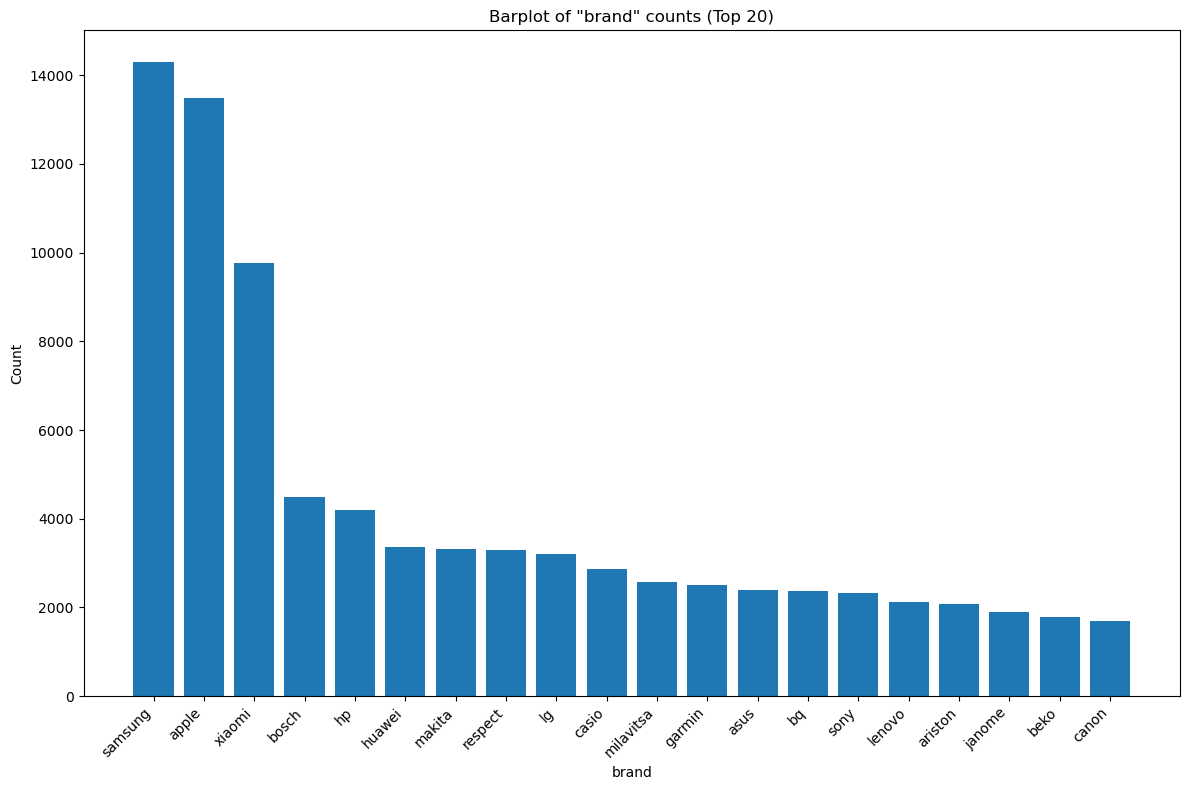

Показаны топ-20 категорий из 1731


In [18]:
plot_cat_distribution(data=df, column_name="brand")

# Анализ столбца `price`

In [19]:
count_nulls(data=df, column_name="price")

Число колонок с NULL: 0 (0.00%)


Минимальное значение:          0.88
Среднее значение:              301.55
Среднеквадратичное отклонение: 390.91
Первый квартиль:               61.52
Медиана:                       146.08
Третий квартиль:               360.11
Максимальное значение:         2574.07


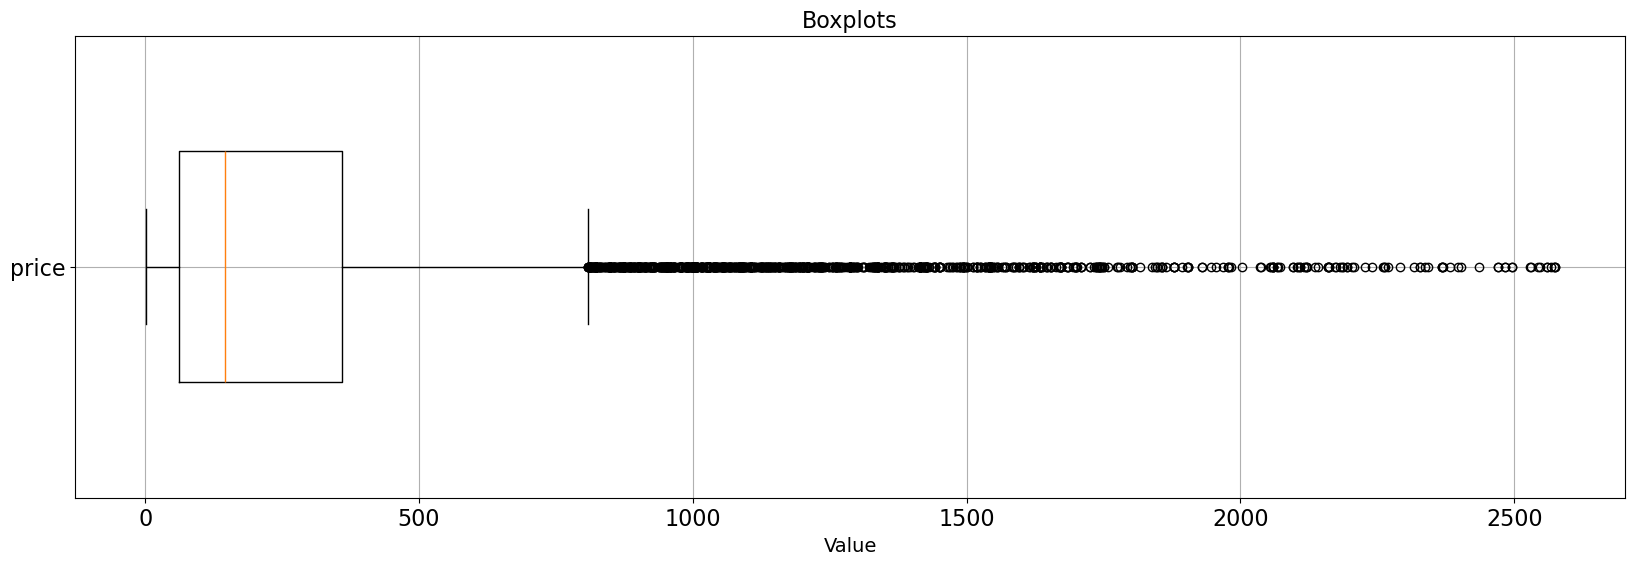

In [20]:
plt.rcParams.update({
    'font.size': 14,                    # базовый размер шрифта
    'axes.titlesize': 16,               # размер заголовка осей
    'axes.labelsize': 14,               # размер подписей осей
    'xtick.labelsize': 16,              # размер подписей по оси X
    'ytick.labelsize': 16,              # размер подписей по оси Y
    'legend.fontsize': 12,              # размер шрифта легенды
    'figure.titlesize': 18              # размер заголовка фигуры
})
plot_boxplots(data=df, columns=["price"])

📊 Диапазон значений price: 0.88 - 2574.07


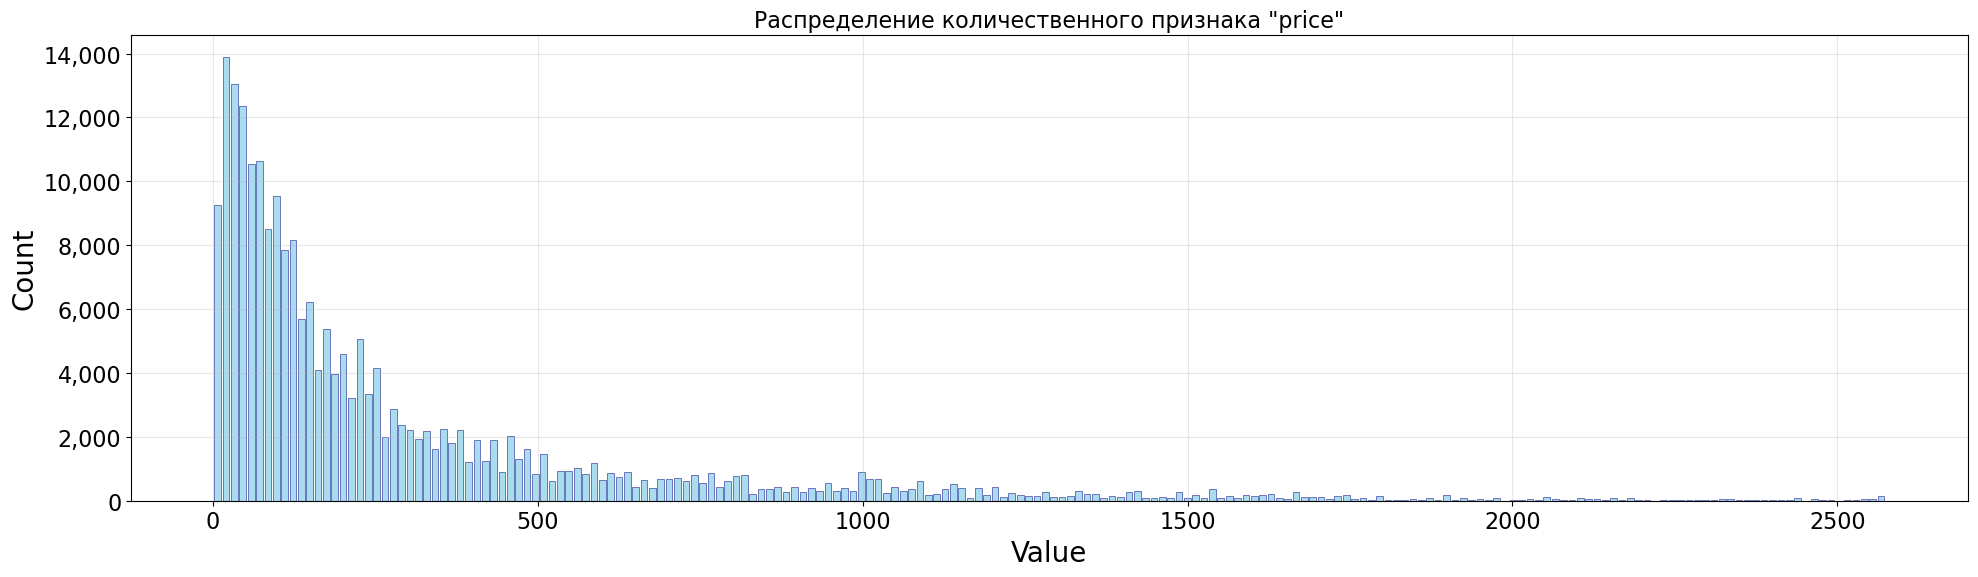

In [21]:
plot_quant_distribution(data=df, column="price")

📊 Диапазон значений price: 0.88 - 699.00


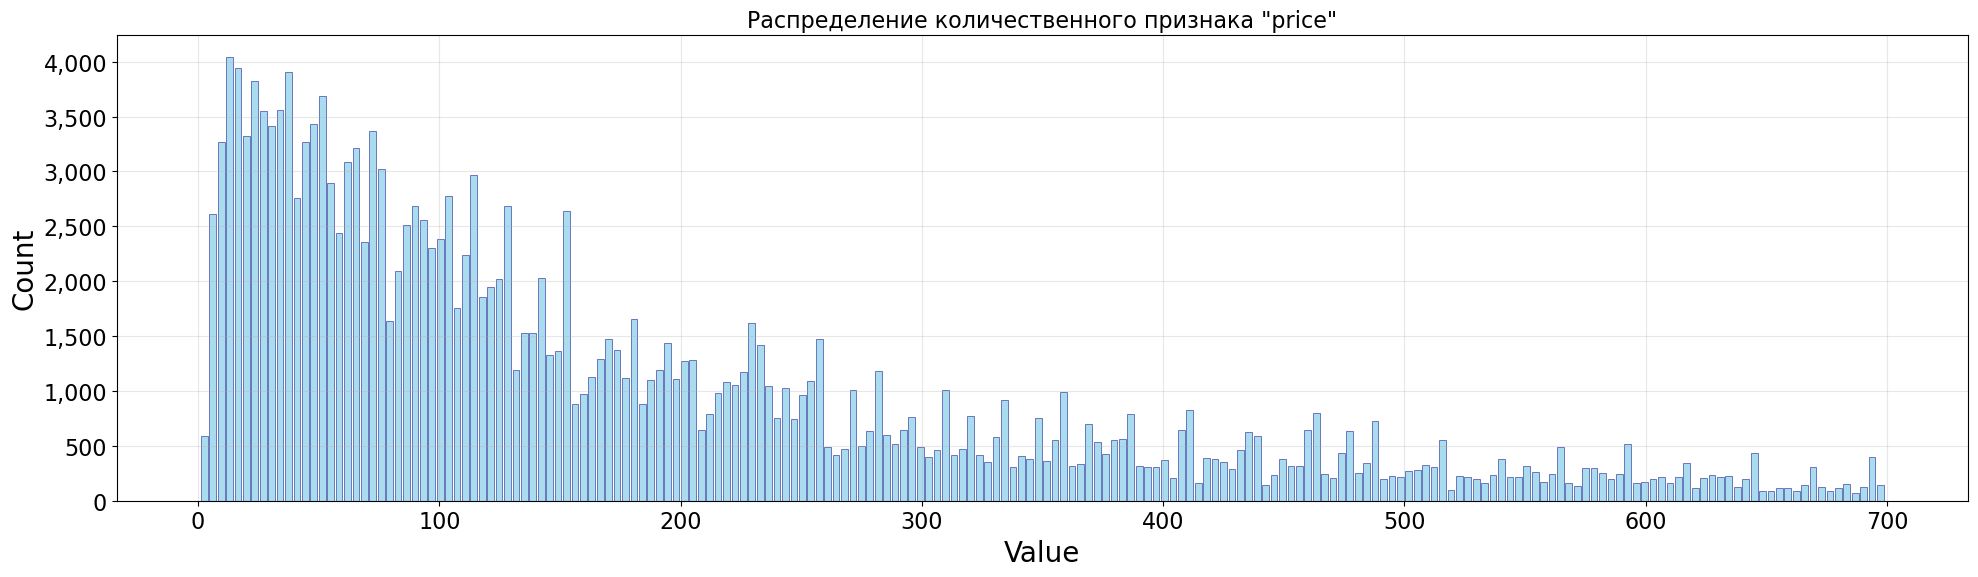

In [22]:
df = df.withColumn(
    "price",
    when(col("price") > 699.0, 699.0)
        .otherwise(col("price"))
)
plot_quant_distribution(data=df, column="price")

In [23]:
df.show()

+----------+----------+-----------+--------------------+-------+------------------+
|event_type|product_id|category_id|       category_code|  brand|             price|
+----------+----------+-----------+--------------------+-------+------------------+
|      view|   1001588|       NULL|[electronics, sma...|  meizu| 128.3000030517578|
|  purchase|   1002062|       NULL|[electronics, sma...|samsung| 77.13999938964844|
|  purchase|   1002101|       NULL|[electronics, sma...|samsung| 370.4100036621094|
|      view|   1002398|       NULL|[electronics, sma...|   sony|251.99000549316406|
|      view|   1002398|       NULL|[electronics, sma...|   sony|252.02999877929688|
|      view|   1002398|       NULL|[electronics, sma...|   sony|252.11000061035156|
|      view|   1002442|       NULL|[electronics, sma...|   sony|128.67999267578125|
|      view|   1002482|       NULL|[electronics, sma...|  meizu| 127.9000015258789|
|      view|   1002482|       NULL|[electronics, sma...|  meizu| 128.3000030

# Анализ столбца `category_id`

In [24]:
count_nulls(data=df, column_name="category_id")

Число колонок с NULL: 224113 (100.00%)


In [25]:
df = df.drop("category_id")
df.show()

+----------+----------+--------------------+-------+------------------+
|event_type|product_id|       category_code|  brand|             price|
+----------+----------+--------------------+-------+------------------+
|      view|   1001588|[electronics, sma...|  meizu| 128.3000030517578|
|  purchase|   1002062|[electronics, sma...|samsung| 77.13999938964844|
|  purchase|   1002101|[electronics, sma...|samsung| 370.4100036621094|
|      view|   1002398|[electronics, sma...|   sony|251.99000549316406|
|      view|   1002398|[electronics, sma...|   sony|252.02999877929688|
|      view|   1002398|[electronics, sma...|   sony|252.11000061035156|
|      view|   1002442|[electronics, sma...|   sony|128.67999267578125|
|      view|   1002482|[electronics, sma...|  meizu| 127.9000015258789|
|      view|   1002482|[electronics, sma...|  meizu| 128.3000030517578|
|      view|   1002484|[electronics, sma...|  meizu| 179.5500030517578|
|      view|   1002494|[electronics, sma...|   sony| 306.6499938

# Анализ признака `category_code`

Является массивом признаков

Количество категорий признака category_code: 150


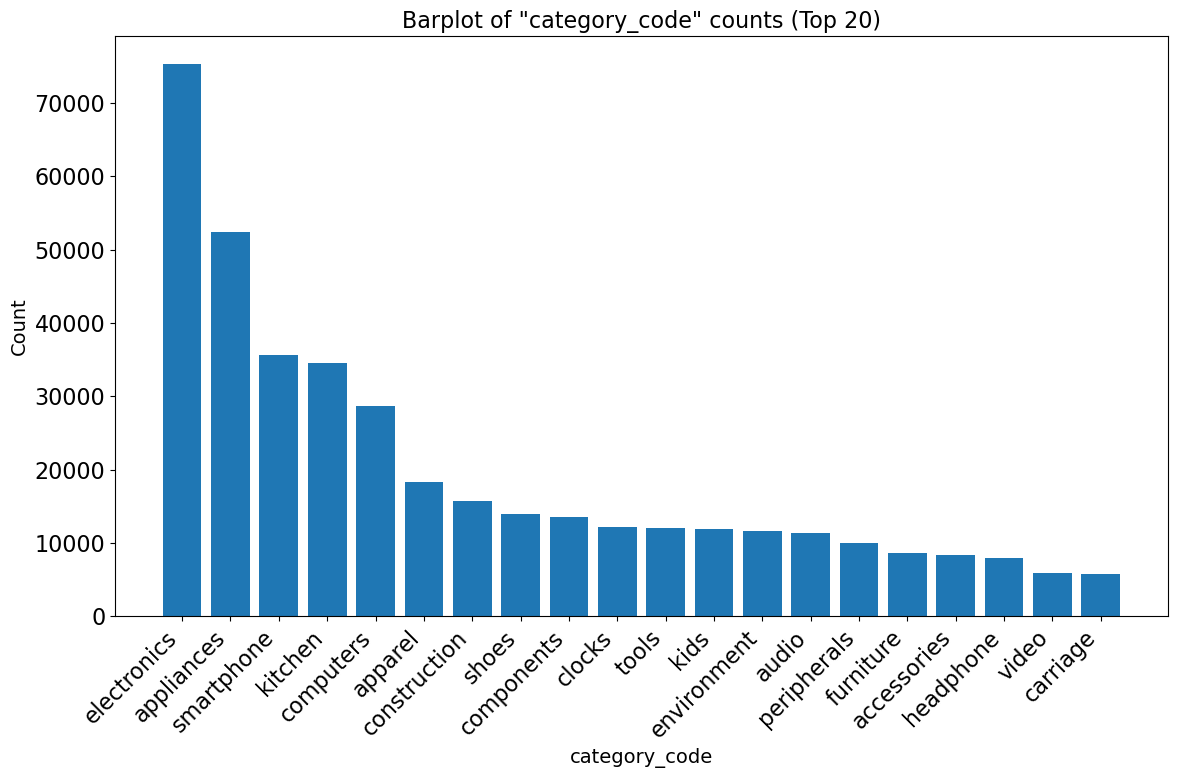

Показаны топ-20 категорий из 150


In [26]:
plot_cat_distribution(data=df, column_name="category_code")

In [27]:
popular_options = get_popular_options(data=df, column="category_code")
popular_options.show()

+-----------+-----+
|    element|count|
+-----------+-----+
|electronics|75279|
| appliances|52421|
| smartphone|35685|
|    kitchen|34508|
|  computers|28741|
+-----------+-----+



In [28]:
df = add_options_columns(data=df, column="category_code", 
                         popular_options=popular_options)
df = df.drop("category_code").cache()
df.show()

+----------+----------+--------------+------------------+-------------------+------------------+--------------------+----------------+-------------------+
|event_type|product_id|         brand|             price|contains_appliances|contains_computers|contains_electronics|contains_kitchen|contains_smartphone|
+----------+----------+--------------+------------------+-------------------+------------------+--------------------+----------------+-------------------+
|      view|   1004372|         honor| 378.3900146484375|              false|             false|                true|           false|               true|
|      view|   3900339|          aqua|30.610000610351562|               true|             false|               false|           false|              false|
|      view|  28400685|         karya|100.38999938964844|              false|             false|               false|           false|              false|
|      view|   1304391|        xiaomi|             699.0|             

# Анализ признака `price`

Признак количественный. Все преобразования аналогичны вышерассмотренным.

Число колонок с NULL: 0 (0.00%)
Минимальное значение:          0.88
Среднее значение:              197.00
Среднеквадратичное отклонение: 187.06
Первый квартиль:               55.32
Медиана:                       125.95
Третий квартиль:               270.25
Максимальное значение:         699.00


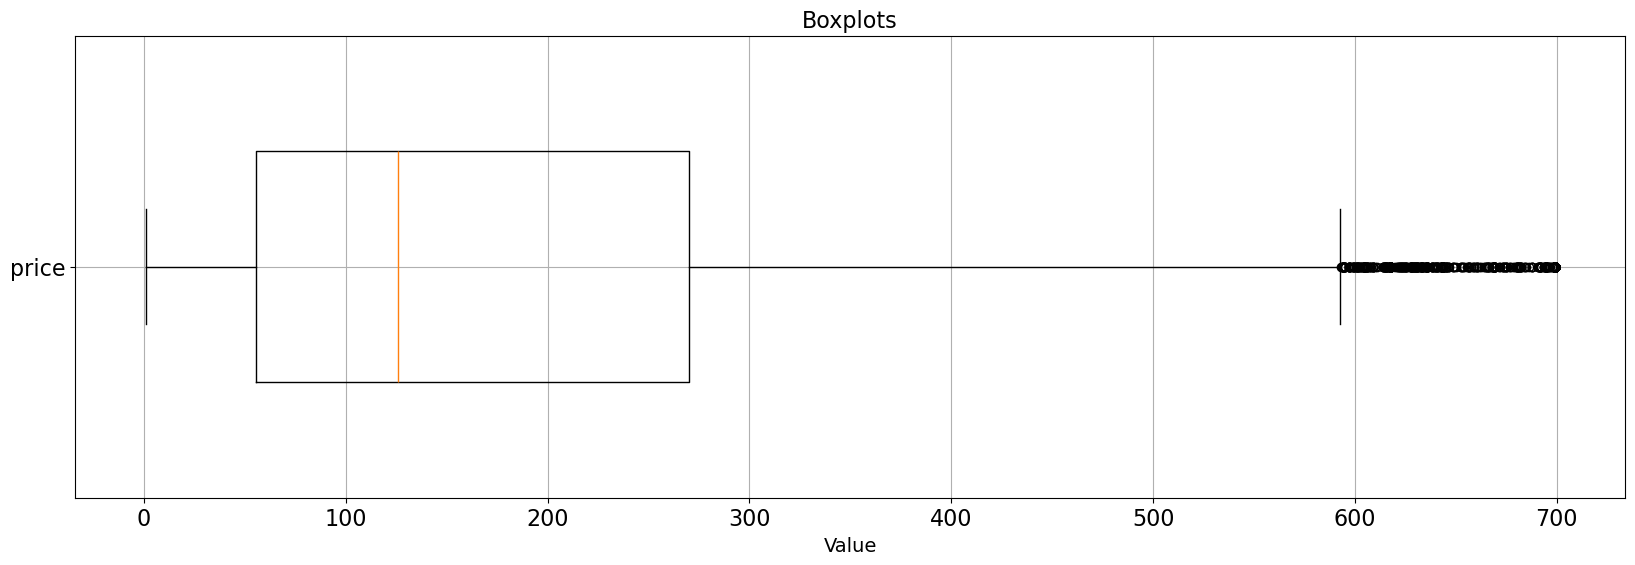

📊 Диапазон значений price: 0.88 - 589.98


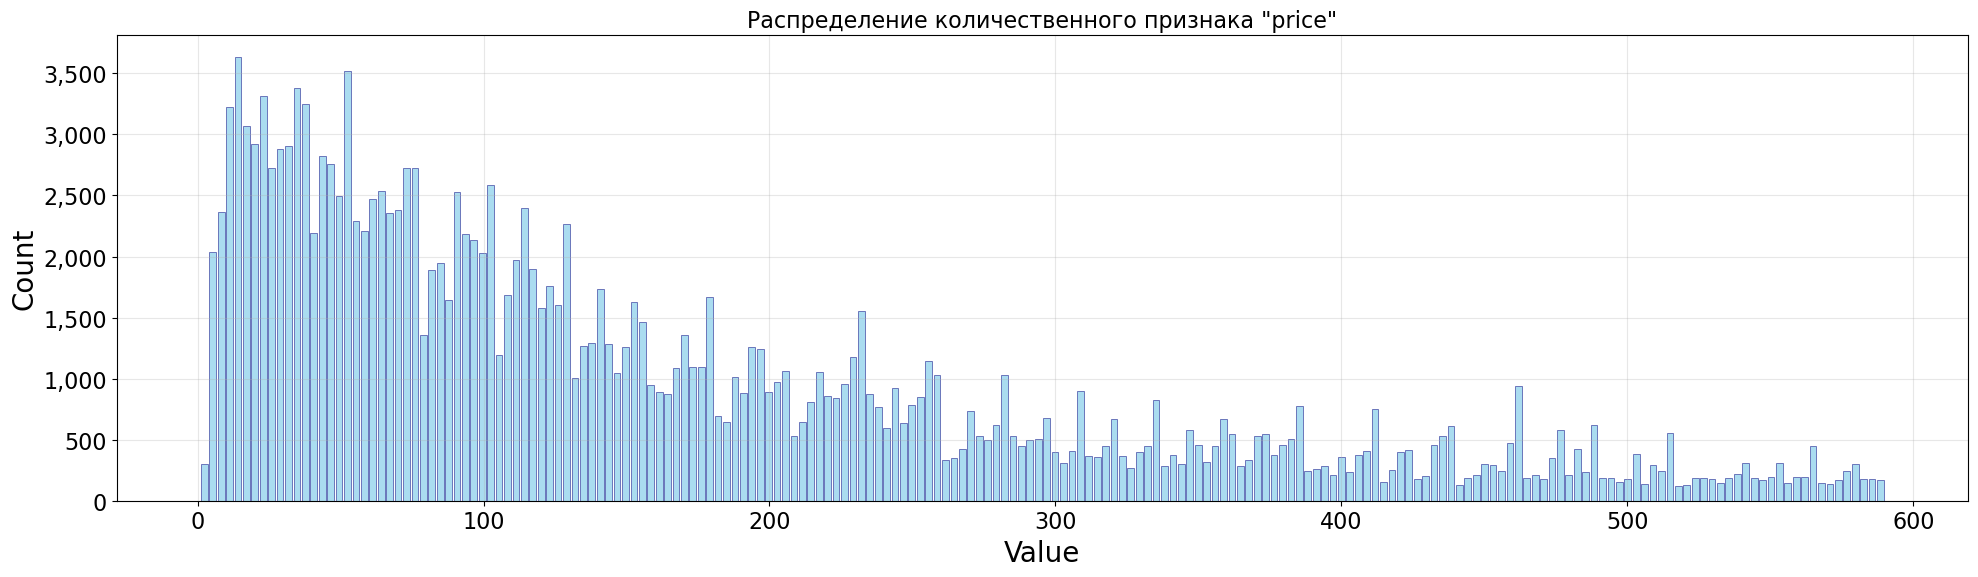

+----------+----------+--------------+------------------+-------------------+------------------+--------------------+----------------+-------------------+
|event_type|product_id|         brand|             price|contains_appliances|contains_computers|contains_electronics|contains_kitchen|contains_smartphone|
+----------+----------+--------------+------------------+-------------------+------------------+--------------------+----------------+-------------------+
|      view|   1004372|         honor| 378.3900146484375|              false|             false|                true|           false|               true|
|      view|   3900339|          aqua|30.610000610351562|               true|             false|               false|           false|              false|
|      view|  28400685|         karya|100.38999938964844|              false|             false|               false|           false|              false|
|  purchase|   4700419|        sho-me| 149.3300018310547|             

In [29]:
count_nulls(data=df, column_name="price")
plot_boxplots(data=df, columns=["price"])

df.filter(col("price") > 590).count()

df = df.filter(col("price") <= 590)
plot_quant_distribution(data=df, column="price")
df.show()

# Анализ признака `event.type`

Признак категориальный. Все преобразования аналогичны вышерассмотренным.

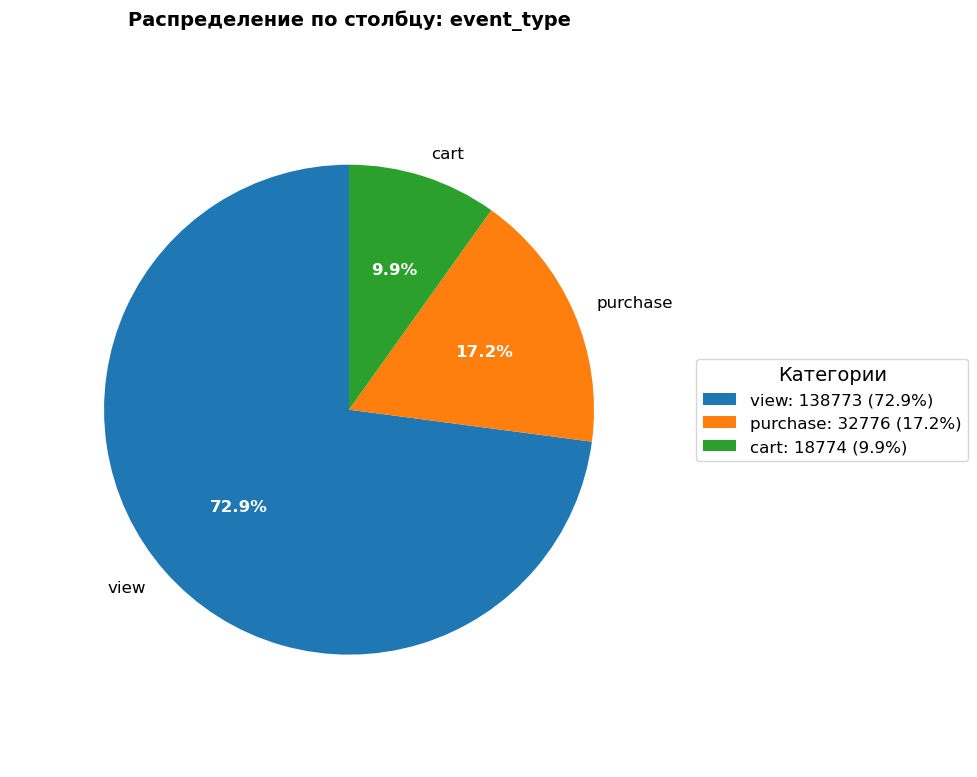

Всего категорий: 3
Показано категорий: 3
Общее количество записей: 190,323


In [30]:
plot_pie_chart(data=df, column_name="event_type")

In [31]:
database_name = "dchel_database"
table_name = "eCommerce_clear_data"

output_path = f"hdfs://namenode:9000/user/dchel/{database_name}/{table_name}"

print(f"Сохраняем данные в: {output_path}")

df.write.mode("overwrite").option("compression", "snappy").parquet(output_path)

print("Данные успешно сохранены в Parquet формате в HDFS")

Сохраняем данные в: hdfs://namenode:9000/user/dchel/dchel_database/eCommerce_clear_data
Данные успешно сохранены в Parquet формате в HDFS


#### Расчет корреляции между количественными признаками

🔍 Анализируем колонки: ['brand', 'price']
  brand: string
    → преобразована в label encoding (1731 уникальных значений)
  price: float
📊 Числовые колонки для корреляции: ['brand_encoded', 'price']


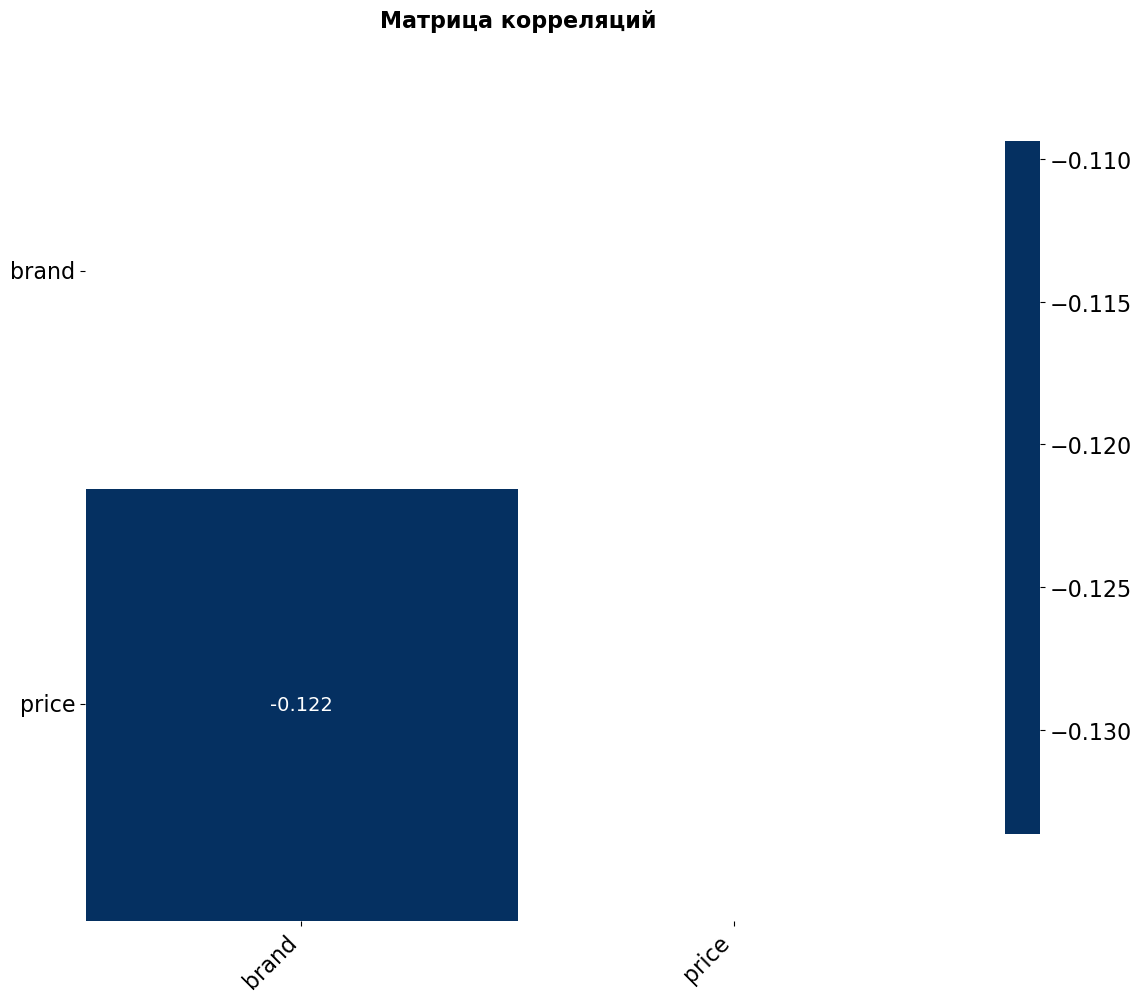


📈 Статистика корреляций:
   Проанализировано колонок: 2
   Максимальная корреляция: -0.122
   Минимальная корреляция: -0.122
   Средняя корреляция: -0.122


In [32]:
df = spark.read.parquet(path)
df = df.dropDuplicates(["product_id", "event_type", "price"])
df = df.drop("category_id")
compute_and_visualize_correlation_matrix(
    data=df, columns=["brand", "price"]
)

In [33]:
# План для агрегации
print("=== План для агрегации ===")
agg_df = df.groupBy("brand").agg({"price": "avg", "price": "max"})
agg_df.explain()

# План для фильтрации и проекции
print("=== План для фильтрации ===")
filtered_df = df.filter(col("price") > 100).select("brand", "price")
filtered_df.explain(mode="extended")

=== План для агрегации ===
== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- HashAggregate(keys=[brand#7027], functions=[max(price#6223)])
   +- Exchange hashpartitioning(brand#7027, 200), ENSURE_REQUIREMENTS, [plan_id=5941]
      +- HashAggregate(keys=[brand#7027], functions=[partial_max(price#6223)])
         +- SortAggregate(key=[product_id#6219, event_type#6218, price#6223], functions=[first(brand#6222, false)])
            +- Sort [product_id#6219 ASC NULLS FIRST, event_type#6218 ASC NULLS FIRST, price#6223 ASC NULLS FIRST], false, 0
               +- Exchange hashpartitioning(product_id#6219, event_type#6218, price#6223, 200), ENSURE_REQUIREMENTS, [plan_id=5936]
                  +- SortAggregate(key=[product_id#6219, event_type#6218, knownfloatingpointnormalized(normalizenanandzero(price#6223)) AS price#6223], functions=[partial_first(brand#6222, false)])
                     +- Sort [product_id#6219 ASC NULLS FIRST, event_type#6218 ASC NULLS FIRST, knownfloatingpointno

In [34]:
spark.stop()